<a href="https://colab.research.google.com/github/jing-yu-lim/NST-Content-Image-Reconstruction-with-DEIT-Transformer/blob/main/DEIT_NST_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NST using DEIT


In [ ]:
# DeiT is built on top of timm. BUT version 0.3.2 does not work with pytorch 1.9; use latest timm
!pip install timm==0.4.12

In [2]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
import timm
import torchvision
import torchvision.transforms as T
import numpy as np

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [ ]:
#import the model and freeze the layers
deit=torch.hub.load('facebookresearch/deit:main','deit_base_patch16_224',pretrained=True)

for param in deit.parameters():
    param.requires_grad=False

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deit.to(device)
deit.eval()
print(device)

In [ ]:
IMAGENET_DEFAULT_MEAN

In [4]:
#load image and transform according to DEIT inputs
def load_image(url,max_size=400,shape=None,is_url=True):
    
    if is_url:
        image=Image.open(requests.get(url,stream=True).raw)
    else:
        image=Image.open(url)  

    transform=T.Compose([
                        T.Resize(256, interpolation=3),
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(IMAGENET_DEFAULT_MEAN,IMAGENET_DEFAULT_STD),                         
                        ])
    
    if image.mode !='RGB':
        image=image.convert('RGB')

    image = transform(image).unsqueeze(0)

    return image

In [ ]:
#if image is not from an url, set is_url=False
# doggy: https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*
# elon: 'https://pbs.twimg.com/profile_images/1416443682157473795/dGtFbtht_400x400.jpg'

c_url= 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*'
content_t=load_image(c_url).to(device)

In [6]:
# cybertruck: https://www.autoblog.nl/files/2020/02/cybertruck-hotwheels-2-908x612.jpg
# anime bg: https://i.pinimg.com/originals/c3/76/47/c37647d3cd724c0dc86a7db7627eaba5.jpg

s_url='https://i.pinimg.com/originals/c3/76/47/c37647d3cd724c0dc86a7db7627eaba5.jpg'

style_t=load_image(s_url).to(device)

In [7]:
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [ ]:
#all the transformer blocks in DEIT
for n , p in deit.blocks._modules.items():
    print(n,type(p))

In [9]:
def get_deit_features(im,model=deit,block_num=None):
    block_features=[]
    if block_num == None:
        block_num=[0,2,4,6,8,10]
    hooks=[]

    def hook_fn (self, input, output):
        block_features.append(output)

    for i in block_num:
        hooks.append(model.blocks[i].register_forward_hook(hook_fn))
           
    outputs=model(im)
    for hook in hooks:
        hook.remove()
    
    return dict(zip(block_num,block_features))


In [10]:
#gram matrix
def gram(feature):
  feature=feature.squeeze(0)
  feature=torch.transpose(feature,1,0)
  return torch.matmul(feature,feature.T)

In [18]:
#specify the block number to retrieve features from deit
block_num=[0,1,2,3,4,5,6,7,8,9,10,11]
c_features=get_deit_features(content_t,model=deit,block_num=block_num) 
s_features=get_deit_features(style_t,model=deit,block_num=block_num)

In [ ]:
#768 is the embedding dimension of vision transformer
#196 is because of the number of patches and center crop: 224x224 (img size) /  (16x16) (patch size) = 196 
# +1 classification token
for n,p in c_features.items():
    print(n, p.shape)

In [13]:
import os
import shutil

dir = 'pics'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

In [ ]:
#initialise generated image with noise
gen_image=(torch.rand_like(content_t)).requires_grad_(True).to(device)
# gen_image=content_t.clone().requires_grad_(True).to(device)

fig,ax = plt.subplots(1,3,figsize=(15,10))
ax[0].axis('off')
ax[0].imshow(im_convert(content_t))
ax[0].set_title('Content Image')

ax[1].axis('off')
ax[1].imshow(im_convert(gen_image))
ax[1].set_title('Generated Image')

ax[2].axis('off')
ax[2].imshow(im_convert(style_t))
ax[2].set_title('Style Image')


plt.savefig('/content/pics/NST_before.jpg')


plt.show()

Hyperparameters

In [49]:
#specify the weight of each layer
content_layer_weights=[1]*12
content_layer_weights=dict(zip(block_num,content_layer_weights))

style_layer_weights=[1]*12
style_layer_weights=dict(zip(block_num,style_layer_weights))


overall_content_weight=1e9
overall_style_weight=2e9

steps = 20000
optimizer=torch.optim.Adam([gen_image],lr=0.02)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95,verbose=False)
lr_epoch=1000

In [ ]:
#to kill processes if cuda memory runs out
import torch
torch.cuda.empty_cache()
!/opt/bin/nvidia-smi
!ps -aux|grep python

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [ ]:
for i in range(steps):

    g_features=get_deit_features(gen_image,block_num=block_num)
    total_content_cost=0
    
    #Use the for loop if using the multilayer content weights 
    #for layer_num, w in content_layer_weights.items():
    layer_content_cost = torch.mean((c_features[0]-g_features[0])**2)
    total_content_cost+=1*layer_content_cost

    total_style_cost=0
    for layer_num, w in style_layer_weights.items():
        m,img,dim=g_features[layer_num].size()
        style_gram=gram(s_features[layer_num])
        gen_gram=gram(g_features[layer_num])
        layer_style_cost=torch.mean((style_gram-gen_gram)**2)/(img*dim)
        total_style_cost+=w*layer_style_cost


    total_cost=overall_content_weight*total_content_cost + overall_style_weight*total_style_cost
    
    optimizer.zero_grad()
    total_cost.backward()
    optimizer.step()

    if i%100==0:
        print('Total loss:',total_cost)

    if i%lr_epoch==0:
        scheduler.step() 
        l_rate=optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {l_rate:.7f}')

    if i%500==0:
        print('Step: ',i+1)
        plt.imshow(im_convert(gen_image))
        plt.axis('off')
        plt.savefig(f'/content/pics/gen_im{i}.jpg')
        plt.show()
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content_t))
ax1.set_title("Content-Image",fontsize = 20)
ax1.axis('off')

ax2.imshow(im_convert(gen_image))
ax2.set_title("Generated-Image", fontsize = 20)
ax2.axis('off')

ax3.imshow(im_convert(style_t))
ax3.set_title('Style-Image',fontsize=20)
ax3.axis('off')

plt.savefig('/content/pics/NST_overall.jpg')
plt.show()

In [53]:
from google.colab import files
!zip -r /content/NST_pics.zip /content/pics
files.download('/content/NST_pics.zip')

ModuleNotFoundError: ignored

# Content Image Generation

In [ ]:
import os
import shutil

dir = 'c_pics'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

In [ ]:
block_num=[0]
c_re_features=get_deit_features(content_t,model=deit,block_num=block_num) 

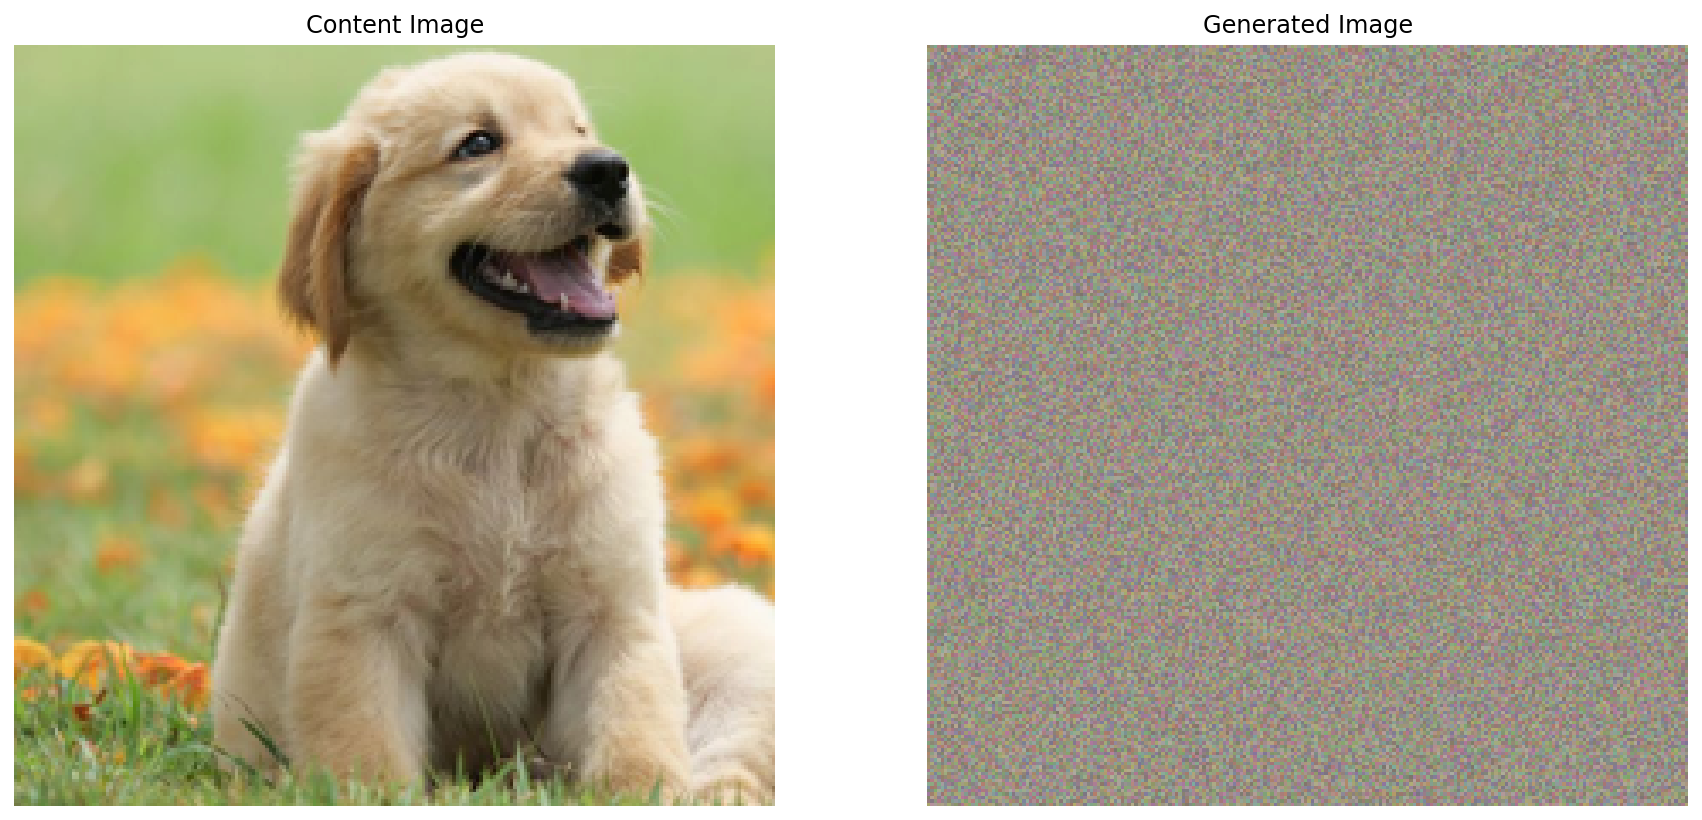

In [ ]:
#initialise generated image with noise
gen_re_image=(torch.rand_like(content_t)).requires_grad_(True).to(device)


fig,ax = plt.subplots(1,2,figsize=(15,10))
ax[0].axis('off')
ax[0].imshow(im_convert(content_t))
ax[0].set_title('Content Image')

ax[1].axis('off')
ax[1].imshow(im_convert(gen_image))
ax[1].set_title('Generated Image')

plt.savefig('/content/pics/content_vs_gen.jpg') #CALL SAVEFIG BEFORE PLT.SHOW
plt.show()

In [ ]:
#if using multi layer, specify the weight of each layer
content_layer_weights=[1.5]*1
content_layer_weights=dict(zip(block_num,content_layer_weights))

overall_content_weight=1e4

steps = 10000
optimizer=torch.optim.Adam([gen_re_image],lr=0.03)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95,verbose=False)
lr_epoch=1000 #how often to update the LR

In [ ]:
for i in range(steps):

    g_re_features=get_deit_features(gen_re_image,block_num=block_num)
    total_content_cost=0
    for layer_num, w in content_layer_weights.items():
        layer_content_cost = torch.mean((c_re_features[layer_num]-g_re_features[layer_num])**2)
        total_content_cost += w*layer_content_cost

    total_cost=overall_content_weight*total_content_cost
    
    optimizer.zero_grad()
    total_cost.backward()
    optimizer.step()

    if i%100==0:
        print('Total loss:',total_cost)

    if i%lr_epoch==0:
        scheduler.step() 
        l_rate=optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {l_rate:.7f}')

    if i%100==0:
        print('Step: ',i+1)
        plt.imshow(im_convert(gen_re_image))
        plt.axis('off')
        plt.savefig(f'/content/c_pics/gen_im_{i}.jpg')
        plt.show()
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_t))
ax1.set_title("Content-Image",fontsize = 20)
ax1.axis('off')

ax2.imshow(im_convert(gen_re_image))
ax2.set_title("Generated-Image", fontsize = 20)
ax2.axis('off')

plt.savefig('/content/c_pics/content_gen_overall.jpg')
plt.show()

In [ ]:
from google.colab import files

!zip -r /content/content_regen.zip /content/c_pics

files.download('/content/content_regen.zip')